<h2>Problem 3</h2>
<t>In this homework, we focus on sequence-to-sequence modeling, similar to homework 4.

Developed a Transformer-based encoder-decoder architecture for English to French Translation. Train the model on the entire dataset and evaluate it on the entire dataset. Report training loss, validation loss, and validation accuracy. Also, try some qualitative validation as well, asking the network to generate French translations for some English sentences. Compare your results against and RNN-based network with attention and without attention.</t>

In [19]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch
import time

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchinfo import summary
import ast

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)

<h3>Tokenize Input Text and Create Dataset:</h3>

In [20]:
class Vocabulary:
    def __init__(self):
        # Initialize dictionaries for word to index and index to word mappings
        self.word2index = {'<SOS>': 0, '<EOS>': 1, '<PAD>': 2}
        self.index2word = {0: '<SOS>', 1: '<EOS>', 2: '<PAD>'}
        self.word_count = {}  # Keep track of word frequencies
        self.n_words = 3  # Start counting from 2 to account for special tokens

    def add_sentence(self, sentence):
        # Add all words in a sentence to the vocabulary
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        # Add a word to the vocabulary
        if word not in self.word2index:
            # Assign a new index to the word and update mappings
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.word_count[word] = 1
            self.n_words += 1
        else:
            # Increment word count if the word already exists in the vocabulary
            self.word_count[word] += 1

# Custom Dataset class for English to French sentences
class EngFrDataset(Dataset):
    def __init__(self, pairs):
        self.eng_vocab = Vocabulary()
        self.fr_vocab = Vocabulary()
        self.pairs = []

        # Process each English-French pair
        for eng, fr in pairs:
            self.eng_vocab.add_sentence(eng)
            self.fr_vocab.add_sentence(fr)
            self.pairs.append((eng, fr))

        # Separate English and French sentences
        self.eng_sentences = [pair[0] for pair in self.pairs]
        self.fr_sentences = [pair[1] for pair in self.pairs]
    
    def pad_sentence(self, sentence, max_length):
        # Split the sentence into words
        words = sentence.split()
        # If the sentence is shorter than max_length, pad it with '<PAD>'
        if len(words) < max_length:
            words += ['<PAD>'] * (max_length - len(words))
        # If the sentence is longer than max_length, truncate it
        elif len(words) > max_length:
            words = words[:max_length]
        return ' '.join(words)

    def __len__(self):
        # Return the number of sentence pairs
        return len(self.pairs)

    def __getitem__(self, idx):
        # Get the sentences by index
        eng_sentence = self.pad_sentence(self.eng_sentences[idx], max_length=MAX_LENGTH)
        fr_sentence = self.pad_sentence(self.fr_sentences[idx], max_length=MAX_LENGTH)
        input_indices = [self.eng_vocab.word2index[word] for word in eng_sentence.split()] + [1]
        target_indices = [self.fr_vocab.word2index[word] for word in fr_sentence.split()] + [1]
        
        return torch.tensor(input_indices, dtype=torch.long), torch.tensor(target_indices, dtype=torch.long)

In [21]:
textPath = "C:/Users/aidan_000/Desktop/UNCC/Github/Intro-to-DL/datasets/text-sequences/E2F.txt"

E2F = []
with open(textPath, 'r') as f:
    E2F = ast.literal_eval(f.read())

MAX_LENGTH = 9

dataset = EngFrDataset(E2F)
training_loader = DataLoader(dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# # Get one batch of data
# inputs, targets = next(iter(data_loader))

# # Convert the tensors back to sentences
# input_sentences = [dataset.eng_vocab.index2word[i.item()] for i in inputs[0]]
# target_sentences = [dataset.fr_vocab.index2word[i.item()] for i in targets[0]]

# # Print the sentences
# print('Input:', ' '.join(input_sentences))
# print('Target:', ' '.join(target_sentences))

In [22]:
def train_model(model, criterion, optimizer, epochs, training_loader, validation_loader, update_interval):
    
    training_losses = []
    validation_losses = []
    validation_accuracies = []
    starting_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_train = time.time()
        
        for inputs, targets in training_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs, targets[:, :-1])  # Exclude <EOS> token from inputs
            
            # Calculate loss
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets[:, 1:].contiguous().view(-1))  # Exclude <SOS> token from targets
            
            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        training_loss = running_loss / len(training_loader)
        training_losses.append(training_loss)
        
        end_train = time.time()
        training_time = end_train - start_train

        model.eval()
        start_valid = time.time()

        with torch.no_grad():
            total_correct = 0
            total_samples = 0
            running_validation_loss = 0.0  # Added this line
            
            for inputs, targets in validation_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs, targets[:, :-1])  # Exclude <EOS> token from inputs
                
                # Calculate validation loss
                validation_loss = criterion(outputs.view(-1, outputs.size(-1)), targets[:, 1:].contiguous().view(-1))  # Exclude <SOS> token from targets
                running_validation_loss += validation_loss.item()  # Added this line
                
                # Calculate accuracy
                predicted = torch.argmax(outputs, dim=-1)
                total_correct += (predicted == targets[:, 1:]).sum().item()
                total_samples += targets[:, 1:].nelement()
                
            validation_loss = running_validation_loss / len(validation_loader)  # Added this line
            validation_losses.append(validation_loss)  # Added this line

            validation_accuracy = total_correct / total_samples * 100
            validation_accuracies.append(validation_accuracy)

        end_valid = time.time()
        validation_time = end_valid - start_valid

        if(epoch + 1) % update_interval == 0:
            rounds_end_time = time.time()
            rounds_time = rounds_end_time - starting_time
            print('Epoch {:3d}, Time (secs) {:.2f}: Training loss {:.4f}, Validation loss {:.4f}, Validation Accuracy {:.2f}%'.format(epoch + 1, rounds_time, training_losses[-1], validation_losses[-1], validation_accuracies[-1]))

    total_time = time.time() - starting_time

    print(f'\nTotal Duration: {total_time:.2f}s')
    print(f'Training Duration: {training_time:.2f}s')
    print(f'Inference Duration: {validation_time:.2f}s')

    print(f'\nFinal Training Loss: {training_losses[-1]:.4f}')
    print(f'Final Validation Loss: {validation_losses[-1]:.4f}')  # Added this line
    print(f'Final Validation Accuracy: {validation_accuracies[-1]:.2f}%')
    
    return training_losses, validation_losses, validation_accuracies, training_time, validation_time

<h3>Next Character Transformer</h3>

In [23]:
class OptimusTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead):
        super(OptimusTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.output_embedding = nn.Embedding(output_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead, batch_first=True)
        decoder_layers = nn.TransformerDecoderLayer(hidden_size, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, src, tgt):
        src = self.embedding(src)
        tgt = self.output_embedding(tgt)
        memory = self.transformer_encoder(src)
        transformer_output = self.transformer_decoder(tgt, memory)
        output = self.fc(transformer_output)
        return output

<h3>Hyperparameters and Training</h3>

In [24]:
SOS_token = 0
EOS_token = 1
PAD_token = 2

learning_rate = 0.0001
epochs = 50

hidden_size = 512
num_layers = 2
nhead = 4

input_size = len(dataset.eng_vocab.word2index)
output_size = len(dataset.fr_vocab.word2index)

model = OptimusTransformer(input_size, hidden_size, output_size, num_layers, nhead).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_token)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

training_losses, validation_losses, validation_accuracies, training_time, validation_time = train_model(model, criterion, optimizer, epochs, training_loader, validation_loader, update_interval=5)

Epoch   5, Time (secs) 0.39: Training loss 3.3841, Validation loss 3.1594, Validation Accuracy 20.35%
Epoch  10, Time (secs) 0.64: Training loss 2.1622, Validation loss 1.9496, Validation Accuracy 41.85%
Epoch  15, Time (secs) 0.88: Training loss 1.1467, Validation loss 0.9726, Validation Accuracy 51.95%
Epoch  20, Time (secs) 1.13: Training loss 0.5314, Validation loss 0.4213, Validation Accuracy 53.97%
Epoch  25, Time (secs) 1.37: Training loss 0.2586, Validation loss 0.1926, Validation Accuracy 53.97%
Epoch  30, Time (secs) 1.61: Training loss 0.1524, Validation loss 0.1089, Validation Accuracy 53.97%
Epoch  35, Time (secs) 1.85: Training loss 0.1080, Validation loss 0.0741, Validation Accuracy 53.97%
Epoch  40, Time (secs) 2.10: Training loss 0.0799, Validation loss 0.0560, Validation Accuracy 53.97%
Epoch  45, Time (secs) 2.34: Training loss 0.0627, Validation loss 0.0452, Validation Accuracy 53.97%
Epoch  50, Time (secs) 2.58: Training loss 0.0527, Validation loss 0.0382, Validat

<h3>Model Training and Evaluation:</h3>

In [25]:
def generate_translation(model, eng_sentence, max_length, eng_vocab, fr_vocab, device):
    # Tokenize and pad the English sentence
    eng_indices = [eng_vocab.word2index.get(word, eng_vocab.word2index['<PAD>']) for word in eng_sentence.split()]
    eng_indices += [eng_vocab.word2index['<EOS>']]  # Add <EOS> token
    eng_indices = torch.tensor(eng_indices, dtype=torch.long).unsqueeze(0).to(device)  # Move to model's device

    # Initialize French translation with <SOS> token
    fr_indices = [fr_vocab.word2index['<SOS>']]
    
    # Disable gradient computation
    with torch.no_grad():
        model.eval()
        # Loop to generate French translation
        for _ in range(max_length):
            # Convert French translation indices to tensor
            fr_tensor = torch.tensor(fr_indices, dtype=torch.long).unsqueeze(0).to(device)  # Move to model's device
            
            # Predict the next token in the French translation
            output = model(eng_indices, fr_tensor)
            next_token_index = torch.argmax(output[:, -1, :], dim=-1).item()
            
            # If the predicted token is <EOS>, stop generating
            if next_token_index == fr_vocab.word2index['<EOS>']:
                break
            
            # Add the predicted token to the French translation after <SOS>
            fr_indices.append(next_token_index)
    
    # Convert French translation indices to words
    fr_sentence = ' '.join([fr_vocab.index2word[index] for index in fr_indices[1:]])  # Exclude <SOS>
    return fr_sentence

num_examples = 5


for i in range(num_examples):

    sentence = dataset.eng_sentences[i]

    translation = generate_translation(model, sentence, len(sentence.split()), dataset.eng_vocab, dataset.fr_vocab, device)
    
    # Print the original and translated sentences
    print(f'Example {i + 1}:')
    print('Original Sentence:', sentence)
    print('Translated Sentence:', translation)
    print()

Example 1:
Original Sentence: I am cold
Translated Sentence: de nouveau chaque

Example 2:
Original Sentence: You are tired
Translated Sentence: es fatigué es

Example 3:
Original Sentence: He is hungry
Translated Sentence: de la musique

Example 4:
Original Sentence: She is happy
Translated Sentence: est heureuse est

Example 5:
Original Sentence: We are friends
Translated Sentence: sommes amis sommes



In [26]:
Optimus_stats = summary(model, [(input_size,), (MAX_LENGTH + 1,)], batch_dim=None, dtypes=[torch.long, torch.long], verbose=2, col_width=16, col_names=["kernel_size", "output_size", "num_params", "mult_adds"], row_settings=["var_names"])

print(f'\n========================================= Model Training Time ==========================================')
print(f'Training Duration: {training_time:.2f}s, Inference Duration: \t{validation_time:.2f}s')
print(f'==========================================================================================================')

print(f'\n============================================ Model Accuracy ============================================')
print(f'Training Loss: {training_losses[-1]:.4f}, Inference Loss: {validation_losses[-1]:.4f}, Inference Accuracy: {validation_accuracies[-1]:.2f}%')
print(f'==========================================================================================================')


Layer (type (var_name))                                      Kernel Shape     Output Shape     Param #          Mult-Adds
OptimusTransformer (OptimusTransformer)                      --               [10, 205]        --               --
├─Embedding (embedding)                                      --               [187, 512]       95,744           17,904,128
│    └─weight                                                [512, 187]                        └─95,744
├─Embedding (output_embedding)                               --               [10, 512]        104,960          1,049,600
│    └─weight                                                [512, 205]                        └─104,960
├─TransformerEncoder (transformer_encoder)                   --               [187, 512]       --               --
│    └─layers.0.self_attn.in_proj_weight                     [1536, 512]                       ├─786,432
│    └─layers.0.self_attn.in_proj_bias                       [1536]                      

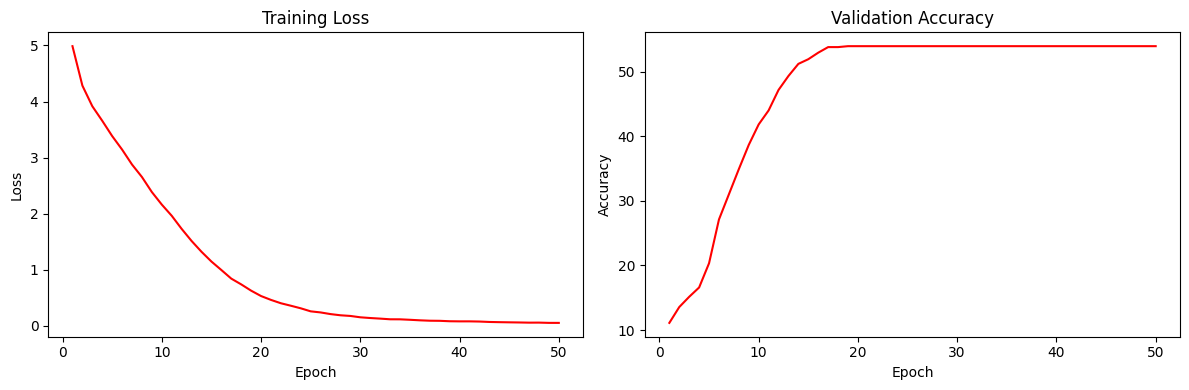

In [27]:
epochs_range = range(1, epochs + 1)
# Plot Training Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_losses, color = 'red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, validation_accuracies, color = 'red')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()